In [1]:
from column_distance import *
import numpy as np
from Bio import motifs
from Bio.motifs import Motif
from pyjaspar import jaspardb
from scipy import stats

In [2]:
# get sample data
jdb = jaspardb()
motif1 = jdb.fetch_motif_by_id('MA0293.1')
motif2 = jdb.fetch_motif_by_id('MA0301.1')
motif3 = jdb.fetch_motif_by_id('MA0384.1')
gapped_pair = (jdb.fetch_motif_by_id('MA0003.2'),jdb.fetch_motif_by_id('MA0524.3'))

In [3]:
def preprocess(motif):
    """
    Return pseudocounted ppm
    """
    return np.array(list(motif.counts.normalize(pseudocounts=0.1).values())).T

In [9]:
def preprocess(motif):
    """
    Return pseudocounted ppm
    """
    return np.array(list(motif.counts.normalize(pseudocounts=0.1).values())).T

In [4]:
ppm1 = preprocess(motif1)
ppm2 = preprocess(motif2)
ppm3 = preprocess(motif3)

In [11]:
def naive_compare(distance_method,ppm1, ppm2, average = np.mean):
    """
    This version compare the columns one by one, both starting from the first. The column distance similarities are averaged
    to calculate the motif similarity. 
    Precondition:
        distance_method: returns a numerical distance value based on two input 4D vectors
        ppm1, ppm2: n * 4 matrices with the same dimensionality
        average: feed in a list, return a numerical value that represents some type of average
    """
    assert ppm1.shape == ppm2.shape
    col_dists = [distance_method(col1, col2) for col1, col2 in zip(ppm1, ppm2)]
    distance = average(col_dists)
    return distance
    

In [5]:
def add_column(ppm, start, end, col=[0.25,0.25,0.25,0.25]):
    """
    helper function to add flanking position at backgrouund frequency
    Precondition:
        ppm: n * 4 numpy matrix, each row represents a position
        start, end: non-negative integers indicating how many new positions to add to the ppm at the [start/end]
        col: background frequency, represented by 4-D vectors that should sum to 1 
    """
    start_m = np.array(start * [col])
    end_m = np.array(end * [col])
    if start == end == 0:
        return ppm
    if start == 0:
        return np.vstack([ppm,end_m])
    elif end == 0:
        return np.vstack([start_m, ppm])
    return np.vstack([start_m, ppm,end_m])

In [6]:
def expand_compare(col_dist,ppm1,ppm2,bg=[0.25,0.25,0.25,0.25],average = np.mean):
    """
    Slide one motif through the other to check all possible ungapped alignments, the unmatched positions are supplied with
    background probability.
    Preconditions:
        col_dist: returns a numerical distance value based on two input 4D vectors
        ppm1/ppm2: n * 4 numpy matrix, each row represents a position
        bg: background frequency, represented by 4-D vectors that should sum to 1 
        average: feed in a list, return a numerical value that represents some type of average
    """
    off_dist = {}
    # swap the two matrices to ensure that ppm1 is longer than ppm2
    if len(ppm2) > len(ppm1):
        ppm2, ppm1 = ppm1, ppm2
    len1 = len(ppm1)
    len2 = len(ppm2)
    assert len1 >= len2
    # iterate through all possible offsets
    for offset in range(-len(ppm2)+1,len(ppm1)):
        if offset < 0: 
            exp_ppm2 = add_column(ppm2, 0, len1 - offset - len2, col = bg)
            exp_ppm1 = add_column(ppm1, -offset, 0, col = bg)
        elif offset >= 0 and offset <= len1 - len2:
            exp_ppm2 = add_column(ppm2, offset, len1 - len2 - offset, col = bg)
            exp_ppm1 = ppm1
        elif offset > len1 - len2:
            exp_ppm2 = add_column(ppm2, offset, 0, col = bg)
            exp_ppm1 = add_column(ppm1, 0, offset + len2 - len1, col = bg)
        off_dist[offset] = naive_compare(col_dist, exp_ppm1, exp_ppm2, average = average)
    return off_dist
            
            
            

In [7]:
def cut_compare(col_dist, ppm1, ppm2, average = np.mean):
    """
    Slide one motif through the other to check all possible ungapped alignments. Only consider the overlapping region
    Preconditions:
        col_dist: returns a numerical distance value based on two input 4D vectors
        ppm1/ppm2: n * 4 numpy matrix, each row represents a position
        average: feed in a list, return a numerical value that represents some type of average
    """    
    off_dist = {}
    # swap the two matrices to ensure that ppm1 is longer than ppm2
    if len(ppm2) > len(ppm1):
        ppm2, ppm1 = ppm1, ppm2
    len1 = len(ppm1)
    len2 = len(ppm2)
    assert len1 >= len2
    for offset in range(-len(ppm2)+1,len(ppm1)):
        if offset < 0: 
            cut_ppm2 = ppm2[-offset:]
            cut_ppm1 = ppm1[:(len2 + offset)]
        elif offset >= 0 and offset <= len1 - len2:
            cut_ppm2 = ppm2
            cut_ppm1 = ppm1[offset:len2 + offset]
        elif offset > len1 - len2:
            cut_ppm1 = ppm1[offset:]
            cut_ppm2 = ppm2[:len1 - offset]
        off_dist[offset] = naive_compare(col_dist, cut_ppm1, cut_ppm2, average = average)
    return off_dist

In [8]:
import matplotlib.pyplot as plt

In [13]:
def compare_align(col_dist,ppm1,ppm2, bg = [0.25,0.25,0.25,0.25]):
    """
    Helper function to compare the expand/cut motif comparison methods given two ppm and the distance method
    Preconditions:
        col_dist: returns a numerical distance value based on two input 4D vectors
        ppm1/ppm2: n * 4 numpy matrix, each row represents a position
        bg: background frequency, represented by 4-D vectors that should sum to 1 (only expand_compare will use it)
    Motif distance is calculated via np.mean
    """
    plot, ax = plt.subplots()
    exp_results = expand_compare(col_dist, ppm1, ppm2,bg = bg)
    cut_results = cut_compare(col_dist, ppm1, ppm2)
    plt.plot(exp_results.keys(), exp_results.values(),label = "Expanded Motif Comparison")
    plt.plot(cut_results.keys(), cut_results.values(), label = "Overlap Motif Comparison")
    plt.legend()
    plt.title("Comparison of Two Motif Alignment (sliding) Strategies")
    ax.set_xticks(list(exp_results.keys()))
    ax.set_ylim(bottom = 0, top = None)
    ax.set_xlabel("offset (positions)")
    ax.set_ylabel("motif distance")
    return

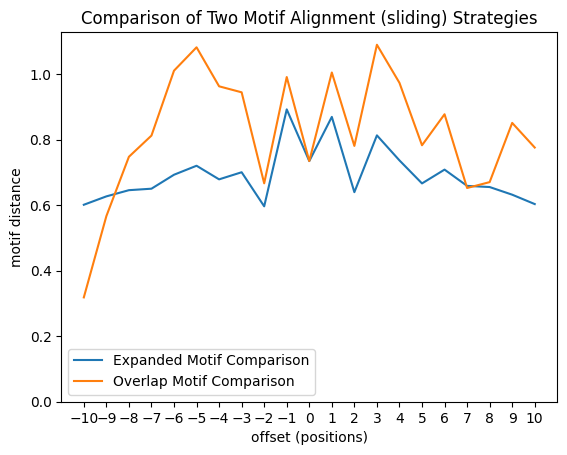

In [15]:
compare_align(Euclidean_Distance, ppm1,ppm3)
# also compare ppm1 and ppm2. These two correspond to figure 2 in the paper. 

In [22]:
def compare_distance(ppm1,ppm2, bg = [0.25,0.25,0.25,0.25], average = np.mean):
    """
    Helper function to compare different column-wise distance measurements in terms of sliding alignment of expanded motifs
    Preconditions:
        ppm1/ppm2: n * 4 numpy matrix, each row represents a position
        average: input a list, output some numerical value representing some type of average
    """
    plot, ax = plt.subplots()
    l2_results = expand_compare(Euclidean_Distance, ppm1, ppm2, bg = bg, average = average)
    js_results = expand_compare(Jensen_Shannon_Distance,ppm1,ppm2,bg = bg, average = average)
    kl_results = expand_compare(Kullback_Leibler_Distance,ppm1,ppm2, bg = bg, average = average)
    pc_results = expand_compare(Pearson_CC_Distance,ppm1,ppm2,bg = bg, average = average)
    l2_values = np.array(list(l2_results.values())) / sum(l2_results.values())
    js_values = np.array(list(js_results.values())) / sum(js_results.values())
    kl_values = np.array(list(kl_results.values())) / sum(kl_results.values())
    pc_values = np.array(list(pc_results.values())) / sum(pc_results.values())
    plt.plot(l2_results.keys(),l2_values,label = "Euclidean_Distance")
    plt.plot(js_results.keys(),js_values,label = "Jensen_Shannon_Distance")
    plt.plot(kl_results.keys(), kl_values,label = "Kullback_Leibler_Distance")
    plt.plot(pc_results.keys(),pc_values, label = "Pearson_Correlation_Distance")
    plt.title("Comparison of Different Column-wise Distance Measurements with Gapped Motif Alignment")
    plt.legend()
    ax.set_xticks(list(l2_results.keys()))
    ax.set_ylim(bottom = 0, top = None)
    ax.set_xlabel("offset (positions)")
    ax.set_ylabel("normalized motif distance")
    return

In [23]:
gapped_ppm1 = preprocess(gapped_pair[0])
gapped_ppm2 = preprocess(gapped_pair[1])

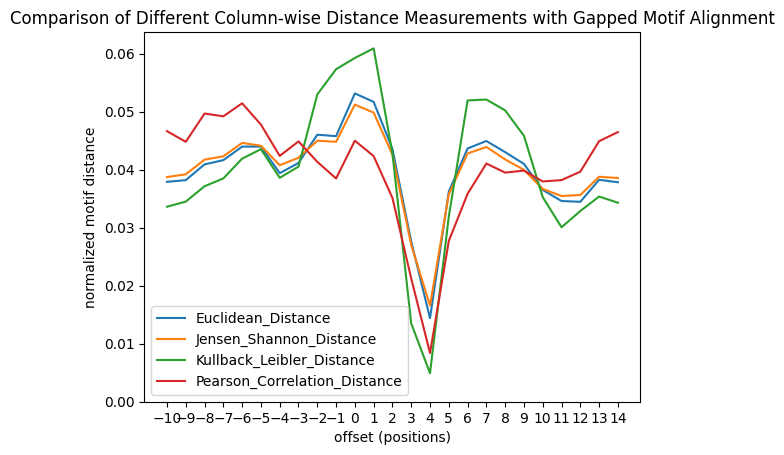

In [24]:
compare_distance(gapped_ppm1, gapped_ppm2, bg = [0.27,0.23,0.23,0.27],average = np.mean)
# also compare (ppm1, ppm2) and (ppm1, ppm3). These correspond to figure 3 in the paper. 


In [24]:
def distance_offset(col_dist, ppm1, ppm2, align_method, bg = [0.25,0.25,0.25,0.25], average = np.mean):
    """
    Return the shortest alignment distance between ppm1, ppm2 as well as the offset of the two motifs for calculating this distance,
      calculated via column-wise distance measurement [col_dist] with [align_method]. The offset indicates how many positions the second 
      motifs start position differs from the first motifs' start position. If offset is 1, it indicates that the best alignment is:
      [0, len(motif1)] and [offset, len(motif2) + offset]
    If the alignment method is chosen to be "expand", the algorithm will calculate a threshold to see whether the minimum value
    really indicates a meaningful motif alignment. If not, the algorithm will return the mean distance of all possible alignments (as all are possible). 
    Preconditions:
        col_dist: returns a numerical distance value based on two input 4D vectors
        ppm1/ppm2: n * 4 numpy matrix, each row represents a position
        bg: background frequency, represented by 4-D vectors that should sum to 1 (only expand_compare will use it)
        alignment_method: ["expand","overlap"]
    """
    # if swapped, the offset should reverse the sign to indicate that the first motif is taken as relative. 
    swap = 1
    if len(ppm2) > len(ppm1):
        swap = -1
    if align_method == "expand":
        # The threshold is calculated as the distance when the motifs are not overlapping with each other. 
        threshold = naive_compare(col_dist, add_column(ppm1,0, len(ppm2),bg), add_column(ppm2,len(ppm1),0,bg), average = average)
        output = expand_compare(col_dist, ppm1,ppm2, average = average)
        min_key = min(output, key=output.get)
        min_value = output[min_key]
        if min_value < threshold:
            # This might be a meaningful alignment
            return min_value, int(min_key) * swap
        else:
            # just return the mean distance of all possible alignments
            return np.mean(list(output.values())), None
    elif align_method == "overlap":
        return min(list(cut_compare(col_dist, ppm1, ppm2, average = average).values())), None

In [37]:
def distance(col_dist, ppm1, ppm2, align_method, bg = [0.25,0.25,0.25,0.25], average = np.mean):
    """
    Return the shortest alignment distance between ppm1, ppm2, calculated via column-wise distance measurement [col_dist] with [align_method]. 
    If the alignment method is chosen to be "expand", the algorithm will calculate a threshold to see whether the minimum value
    really indicates a meaningful motif alignment. If not, the algorithm will return the mean distance of all possible alignments (as all are possible). 
    Preconditions:
        col_dist: returns a numerical distance value based on two input 4D vectors
        ppm1/ppm2: n * 4 numpy matrix, each row represents a position
        bg: background frequency, represented by 4-D vectors that should sum to 1 (only expand_compare will use it)
        alignment_method: ["expand","overlap"]
    """
    if align_method == "expand":
        output = list(expand_compare(col_dist, ppm1,ppm2, average = average).values())
        minimum =  min(output)
        # The threshold is calculated as the distance when the motifs are not overlapping with each other. 
        threshold = naive_compare(col_dist, add_column(ppm1,0, len(ppm2),bg), add_column(ppm2,len(ppm1),0,bg), average = average)
        if minimum < threshold:
            return minimum
        else:
            # just return the mean distance of all possible alignments
            return np.mean(output)
    elif align_method == "overlap":
        return min(list(cut_compare(col_dist, ppm1, ppm2, average = average).values()))

In [29]:
distance_offset(Euclidean_Distance, ppm1, ppm1, "expand", average = np.mean)

(0.0, 0)